# Applying regression models with pipelines

For this notebook we will:
* Bring over the dataframe we generated in the previous step (Generating features and wrangling)
* Creating a preprocessing pipeline with sklearn to feed our data and apply different models
* Test our first hypothesis:  We can guess the number of monthly interactions a user have with the characteristics of an uploaded recipe, and the history of the user who uploaded it.
* Test our second hypothesis: Changing our dependent variable to be the number of interactions that will happen only in the month after the recipe is submitted, to be able to predict short term activity in our site.

First we import general libraries for data manipulation and plotting, and we will bring sklearn libraries later on as we use them.

In [1]:
#Libraries for tables manipulation
import pandas as pd
import numpy as np
import datetime

#Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

#To not receive warning messages
import warnings
warnings.filterwarnings('ignore')

Let's take a look to our data

In [2]:
data = pd.read_csv("../data/mvp_export.csv", index_col=0)

In [3]:
data

,recipe_id,comm_rec_month,in_first30d,rating,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes,minutes,n_steps,n_ingredients,month_posted,days_since_posted
0,137739,0.018541,3,5.0,735,3.068027,4.596259,0.327186,55,11,7,9,4854
1,31490,0.019864,4,3.5,366,5.669399,4.324293,0.320801,30,9,6,6,6041
2,112140,0.005932,1,4.0,7,1.428571,4.714286,0.410158,130,6,13,2,5057
3,59389,0.010453,2,4.5,115,3.721739,4.369417,0.327694,45,11,11,4,5740
4,44061,0.005075,1,5.0,91,9.725275,4.375281,0.310879,190,5,8,10,5911
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231632,486161,0.077754,6,5.0,172,4.093023,4.677495,0.346470,60,7,22,8,2315
231633,493372,0.013749,1,5.0,1,1.000000,5.000000,-0.086061,5,1,13,1,2182
231634,308080,0.038870,5,5.0,2553,4.958480,4.440109,0.339765,40,7,8,6,3859
231635,298512,0.007669,1,1.0,40,2.450000,4.176564,0.332633,29,9,10,4,3912


In [4]:
data.describe()

,recipe_id,comm_rec_month,in_first30d,rating,no_recipes_submitted,avg_comments_recipes,avg_ratings_recipes,avg_sentiment_recipes,minutes,n_steps,n_ingredients,month_posted,days_since_posted
count,231637.000000,231637.000000,231637.000000,231637.000000,231637.000000,231637.000000,231637.000000,231637.000000,2.316370e+05,231637.000000,231637.000000,231637.000000,231637.000000
mean,222014.708984,0.031958,4.888541,4.346246,299.024797,4.888541,4.346246,0.323570,9.398546e+03,9.765499,9.051153,6.310680,4429.917651
std,141206.635626,0.096523,17.532481,0.990806,558.807265,6.109017,0.452617,0.070767,4.461963e+06,5.995128,3.734796,3.429703,1088.577968
min,38.000000,0.004233,1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,0.000000e+00,0.000000,1.000000,1.000000,27.000000
25%,99944.000000,0.007843,1.000000,4.000000,13.000000,2.333333,4.248514,0.307212,2.000000e+01,6.000000,6.000000,3.000000,3715.000000
50%,207249.000000,0.014503,2.000000,4.714286,82.000000,3.687500,4.415544,0.326475,4.000000e+01,9.000000,9.000000,6.000000,4360.000000
75%,333816.000000,0.029354,4.000000,5.000000,313.000000,5.937500,4.547142,0.339765,6.500000e+01,12.000000,11.000000,9.000000,5219.000000
max,537716.000000,8.817945,1613.000000,5.000000,3118.000000,847.000000,5.000000,1.000000,2.147484e+09,145.000000,43.000000,12.000000,7087.000000


We start transforming categoricals into dtype_objects, as well as our index 

In [5]:
data['month_posted'] = data['month_posted'].astype(object)
data['recipe_id'] = data['recipe_id'].astype(object)

### Looking at the distributions
We first take a look in the distribution of our target variables

<AxesSubplot:xlabel='comm_rec_month', ylabel='Density'>

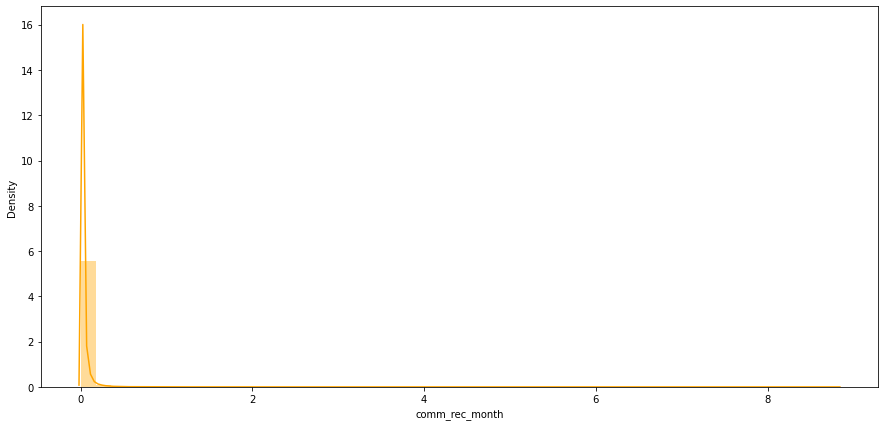

In [6]:
plt.figure(figsize=(15,7))
sns.distplot(data['comm_rec_month'], color='orange')

<AxesSubplot:xlabel='in_first30d', ylabel='Density'>

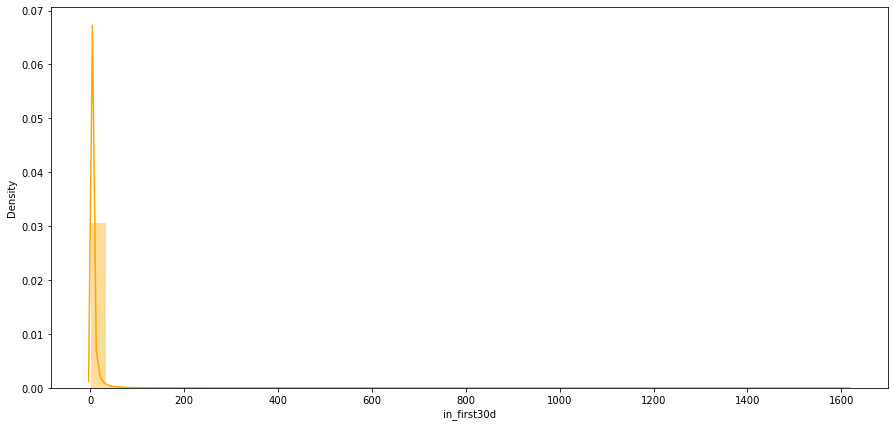

In [7]:
plt.figure(figsize=(15,7))
sns.distplot(data['in_first30d'], color='orange')

<AxesSubplot:xlabel='rating', ylabel='Density'>

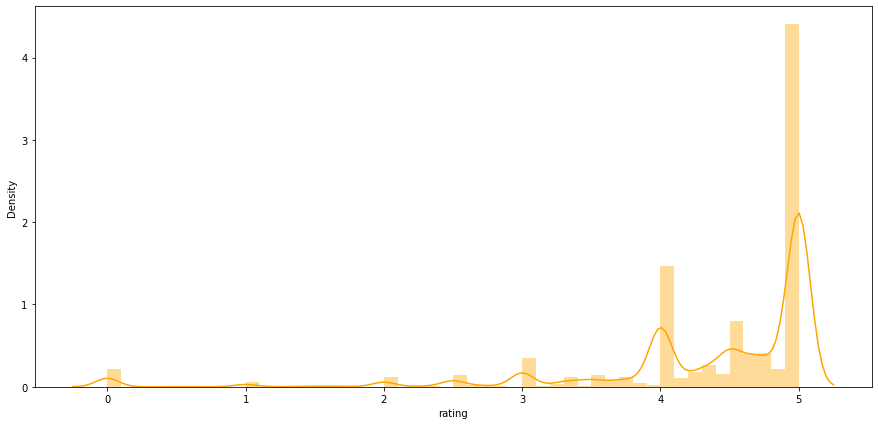

In [8]:
plt.figure(figsize=(15,7))
sns.distplot(data['rating'], color='orange')

checking the distribution of the numerical variables we can see that some scale transformation and we we'll have to deal with some ouliers, as there are very extreme ones, as well as the distributions being very skewed to the right, or to the left in the case of the average ratings. 

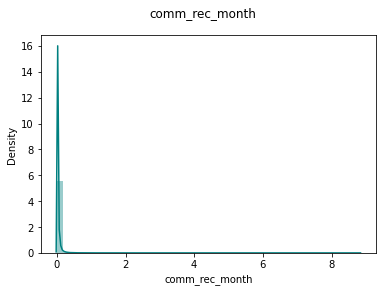

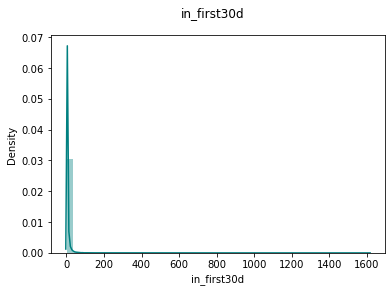

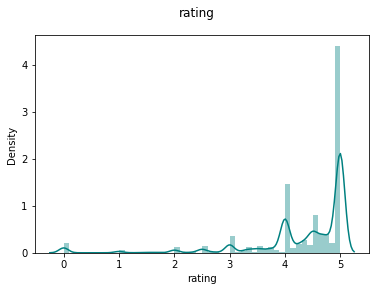

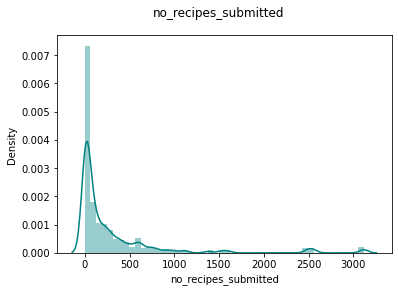

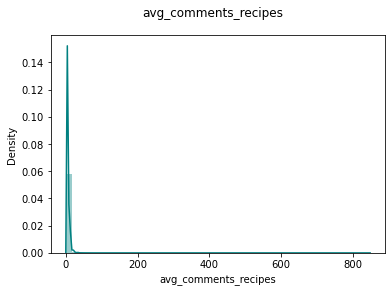

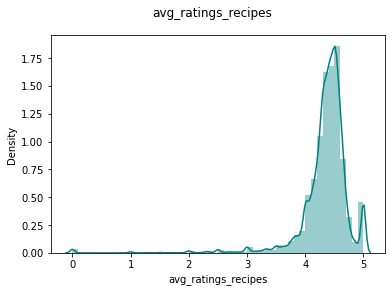

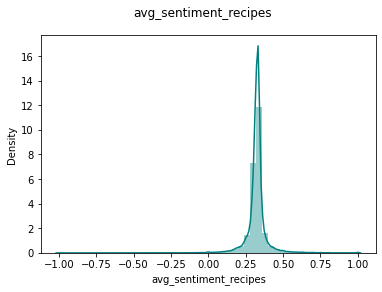

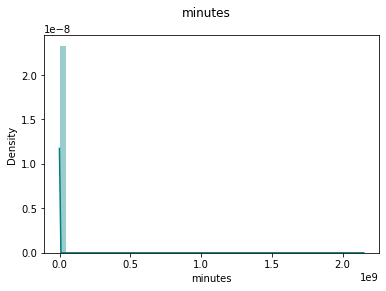

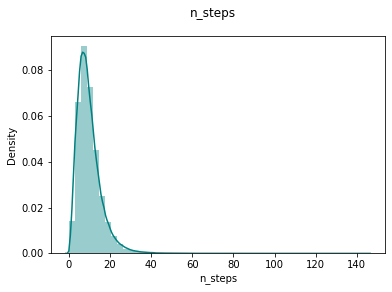

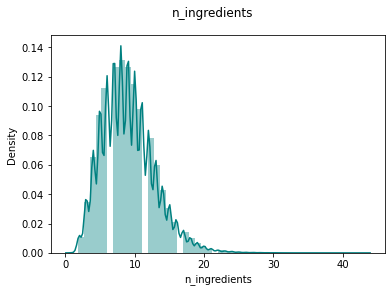

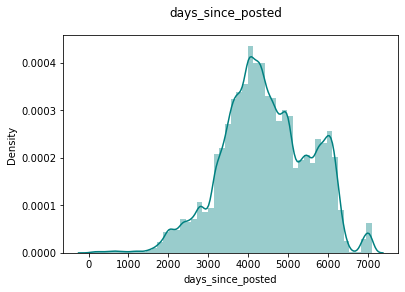

In [9]:
for col in data.select_dtypes([np.number]).columns:
    sns.distplot(data[col], color='teal')
    plt.suptitle(col)
    plt.show()

Seeing the column: days_since_posted we see the distribution of when the recipes were being posted. 
The activity in the page lowered considerably after 2010, that's why we see a sudden rise in this variable. We will remove all recipes posted after 1500 days ago (bigger than 1500) and remove those generated shortly when the page was created, when it was less known (taking all smaller than 6500 days) 

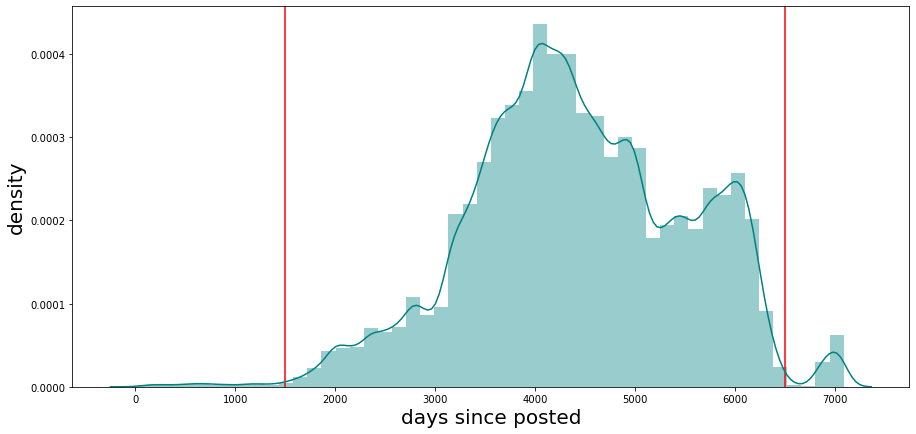

In [10]:
plt.figure(figsize=(15,7))
plt.axvline(1500, color='red')
plt.axvline(6500, color='red')
plot = sns.distplot(data['days_since_posted'], color='teal')
plot.set_xlabel('days since posted',fontsize=20)
plot.set_ylabel('density',fontsize=20)
plt.show();

In [11]:
data = data[data['days_since_posted'].between(1500,6500)]

### Removing outliers
By the look of the distribution of the variables, we will need to clean some outliers and apply some transformation as steps for preprocessing.
We start by checking the numerical variables:

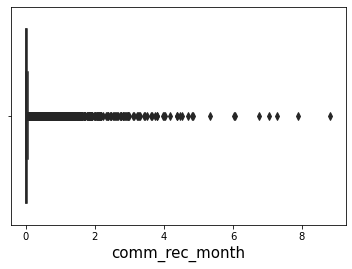

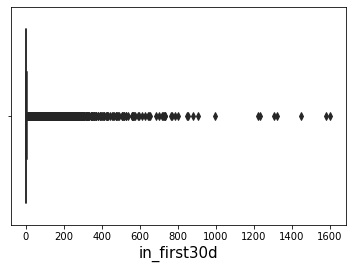

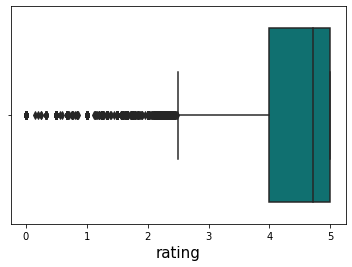

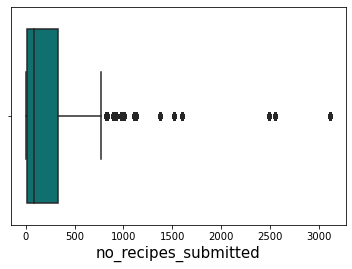

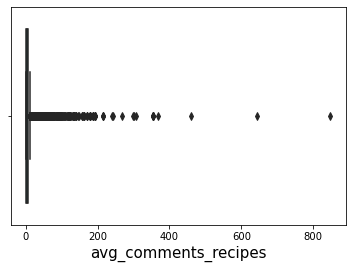

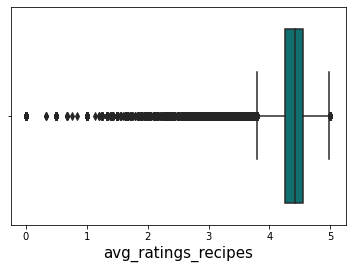

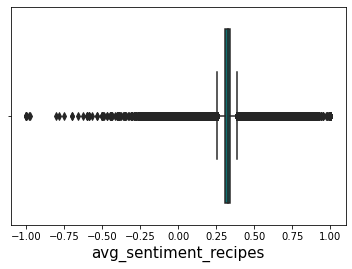

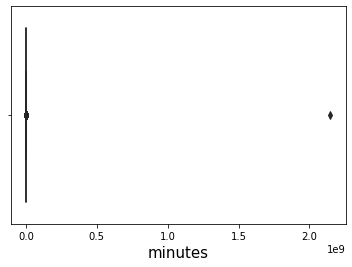

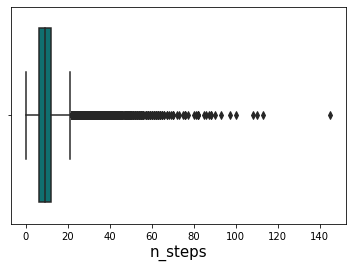

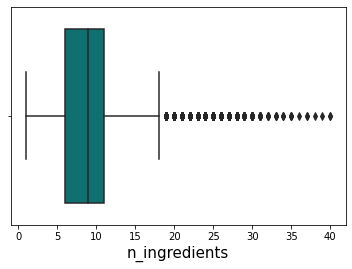

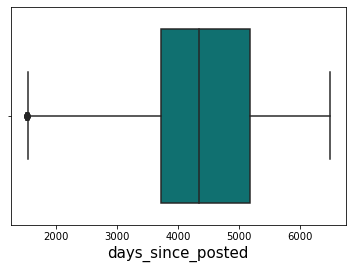

In [12]:
for col in data.select_dtypes([np.number]).columns:
    plot = sns.boxplot(data[col], color='teal')
    plot.set_xlabel(col, fontsize=15)
    plt.show()

We have to be very careful with outliers that correspond to columns other than minutes, n_ingredients and n_steps, as those columns correspond to characteristics of the user that uploaded the recipe, and if we remove users that submitted a lot of recipes, we will remove too many of our database data points. If a good result is not achieved, it might be good to bin these columns and treat them as categoricals

In [13]:
data = data[data['no_recipes_submitted']<2000]
data.shape

(219277, 13)

In [14]:
data = data[data['avg_comments_recipes']<200]
data.shape

(219259, 13)

In [15]:
data = data[data['avg_sentiment_recipes']>-0.75]
data.shape

(219248, 13)

We'll take out all recipes that take over 12 hours to cook

In [16]:
data = data[data['minutes']<720]
data.shape

(216548, 13)

In [17]:
data = data[data['n_steps']<40]
data.shape

(216014, 13)

In [18]:
data = data[data['n_ingredients']<20]
data.shape

(213859, 13)

In [19]:
data = data[data['no_recipes_submitted']<1000]
data.shape

(206562, 13)

### Looking for multicollinearity

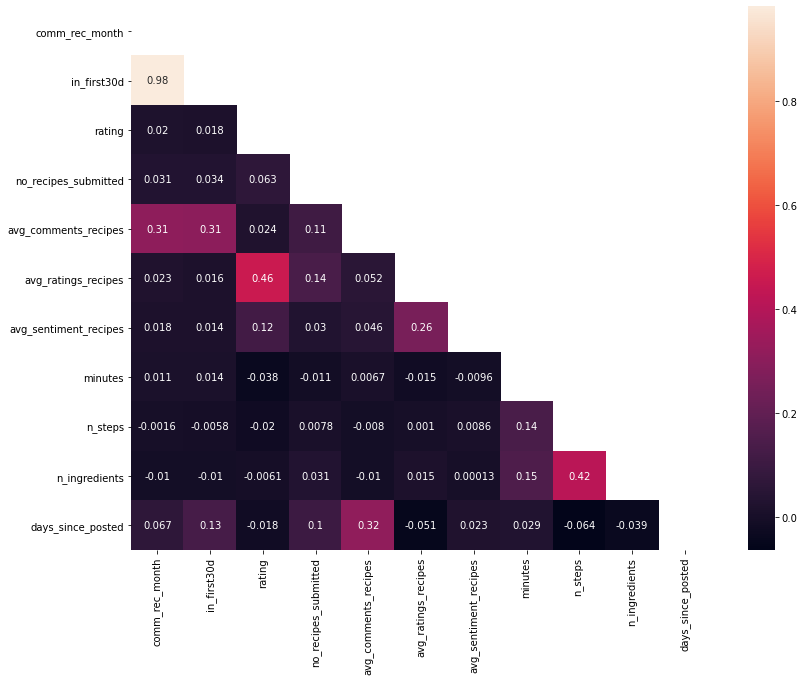

In [20]:
 def corr_matr_show(data):
    correlations_matrix = data.corr()
    mask = np.zeros_like(correlations_matrix)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(13, 10))
    ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
    plt.show()
    
corr_matr_show(data)

From this chart we could take interesting information on how the web works:

* Both dependent variables we want to look for, have a strong correlation. This could indicate that the comments that a recipe receives monthly is strongly determined by the ones received in the first month. 
* Apart from our index and our dependent variables, we can't see any other strong correlation happening, so we won't have to drop any features

## Creating a pipeline
First we need to import all transformers and models we want to use in our pipeline, as well as the pipeline itself

In [21]:
# Preprocessing libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer

# Libraries different regression modelling and evaluation
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


Then we need to define a pipeline of preprocessing for categoricals and numericals separately, as the process we want to put them through is different. 
For categoricals we will use:
* OneHotEncoder: creates a new feature per category and will be labeled as 1 if it belongs to that feature

In [22]:
cat_transf = Pipeline(steps=[('onehot',OneHotEncoder(handle_unknown='ignore'))
                             ])

Then for numericals we will use:
* PowerTransformer: This transformer will alter the scale in a way that heavily skewed data becomes more normalised
* StandardScaler: will scale our data to have a mean of 0 and standard deviation of 1, preserving the proportions between all data

In [23]:
num_transf = Pipeline(steps=[('transformer', PowerTransformer()),
                             ('scaler', StandardScaler())
                             ])

This part of the pipeline will choose columns from our data, and put them through one or another pipeline. We use selector function to choose columns based on the type.

In [24]:
preprocessor = ColumnTransformer(transformers=[('cat', cat_transf, selector(dtype_include="object")),
                                               ('num', num_transf, selector(dtype_exclude="object"))
                                               ])

### Split X and y to pedict the number of interactions in the first 30 days


In [25]:
X = data.drop(['recipe_id','comm_rec_month','rating'], axis=1)
y = data['in_first30d']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

## Prototyping pipelines for different models
Prototyping the pipeline: Here comes all together, we will first preprocess our data through the previous parts of the pipeline, and then apply a regression model. For this project we will not go deep into improving the models and adjusting hyperparameters, as the purpose here was to learn how to deploy these pipelines and make them work. To achieve better models we would have to research and work more in the specific preprocessing steps, and apply them to each one of the regressors

### Linear Regression

In [27]:
pipe_lr = Pipeline([('preprocessing', preprocessor),
                    ('regressor',linear_model.LinearRegression())
                    ])

In [28]:
pipe_lr.fit(X_train, y_train)
print("model score: %.3f" % pipe_lr.score(X_test, y_test))

model score: 0.128


In [29]:
y_test_predict = pipe_lr.predict(X_test)

In [30]:
print("RMSE:      {:.3f}".format(mean_squared_error(y_test, y_test_predict, squared=False)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

RMSE:      15.356
R2 score: 0.128


### Stochastic Gradient Descent (SGD) Regression

In [31]:
pipe_SGDreg = Pipeline([('preprocessing', preprocessor),
                        ('SGDregressor',linear_model.SGDRegressor())
                        ])

In [32]:
pipe_SGDreg.fit(X_train, y_train)
print("model score: %.3f" % pipe_SGDreg.score(X_test, y_test))

model score: 0.127


In [33]:
y_test_predict = pipe_SGDreg.predict(X_test)

In [34]:
print("RMSE:      {:.3f}".format(mean_squared_error(y_test, y_test_predict, squared=False)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

RMSE:      15.366
R2 score: 0.127


### Poisson Regression

In [35]:
pipe_Preg = Pipeline([('preprocessing', preprocessor),
                      ('Poissonregressor',linear_model.PoissonRegressor())
                      ])

In [36]:
pipe_Preg.fit(X_train, y_train)
print("model score: %.3f" % pipe_Preg.score(X_test, y_test))

model score: 0.752


In [37]:
y_test_predict = pipe_Preg.predict(X_test)

In [38]:
print("RMSE:      {:.3f}".format(mean_squared_error(y_test, y_test_predict, squared=False)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

RMSE:      14.191
R2 score: 0.256


### Random Forest Regressor

In [39]:
pipe_RFreg = Pipeline([('preprocessing', preprocessor),
                       ('random forest reg', RandomForestRegressor(max_depth=2, random_state=66))
                       ])

In [40]:
pipe_RFreg.fit(X_train, y_train)
print("model score: %.3f" % pipe_RFreg.score(X_test, y_test))

model score: 0.871


In [41]:
y_test_predict = pipe_RFreg.predict(X_test)

In [42]:
print("RMSE:      {:.3f}".format(mean_squared_error(y_test, y_test_predict, squared=False)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

RMSE:      5.919
R2 score: 0.871


* Plotting the predictions vs the real test set

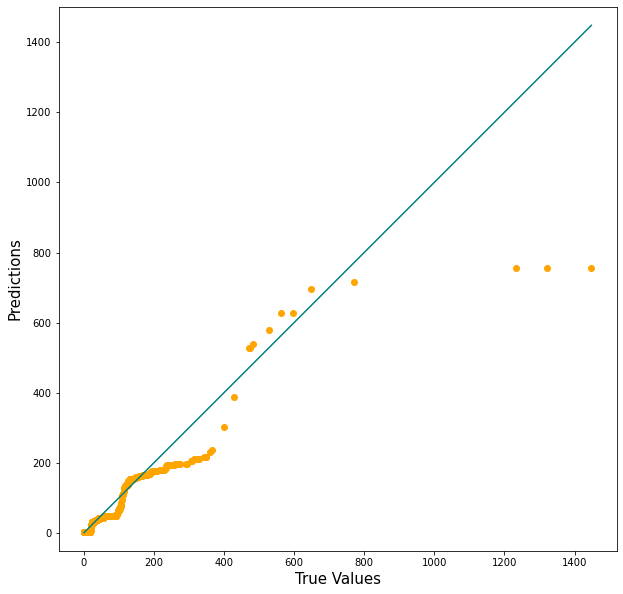

In [43]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_predict, c='orange')

p1 = max(max(y_test_predict), max(y_test))
p2 = min(min(y_test_predict), min(y_test))
plt.plot([p1, p2], [p1, p2], 'teal')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

## Predicting the rating 
We can use the pipelines earlier set to try to predict rating now, we only have to do the split again:

In [44]:
X = data.drop(['recipe_id','comm_rec_month','in_first30d'], axis=1)
y = data['rating']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)

### Random Forest Regressor

In [46]:
pipe_RFreg = Pipeline([('preprocessing', preprocessor),
                       ('random forest reg', RandomForestRegressor(max_depth=2, random_state=66))
                       ])

In [47]:
pipe_RFreg.fit(X_train, y_train)
print("model score: %.3f" % pipe_RFreg.score(X_test, y_test))

model score: 0.942


In [48]:
y_test_predict = pipe_RFreg.predict(X_test)

In [49]:
print("RMSE:      {:.3f}".format(mean_squared_error(y_test, y_test_predict, squared=False)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

RMSE:      0.239
R2 score: 0.942


* Plotting the predictions vs the real test set

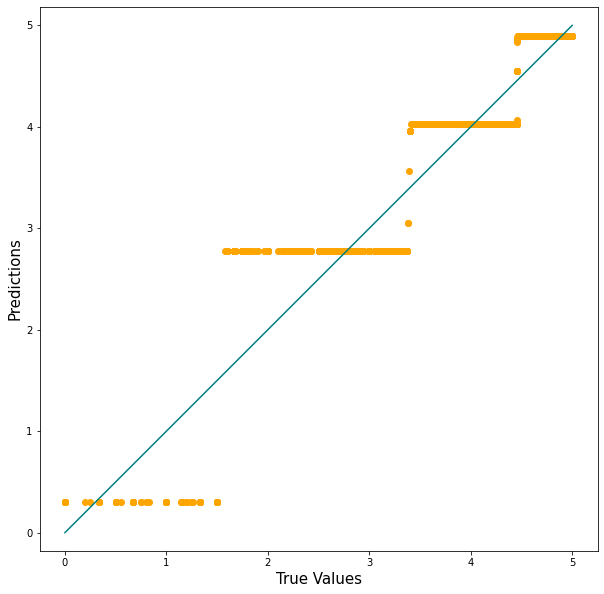

In [50]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_predict, c='orange')

p1 = max(max(y_test_predict), max(y_test))
p2 = min(min(y_test_predict), min(y_test))
plt.plot([p1, p2], [p1, p2], 'teal')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

### Linear Regression

In [51]:
pipe_lr = Pipeline([('preprocessing', preprocessor),
                    ('regressor',linear_model.LinearRegression())
                    ])

In [52]:
pipe_lr.fit(X_train, y_train)
print("model score: %.3f" % pipe_lr.score(X_test, y_test))

model score: 0.806


In [53]:
y_test_predict = pipe_lr.predict(X_test)

In [54]:
print("RMSE:      {:.3f}".format(mean_squared_error(y_test, y_test_predict, squared=False)))
print("R2 score: {:.3f}".format(r2_score(y_test, y_test_predict)))

RMSE:      0.437
R2 score: 0.806


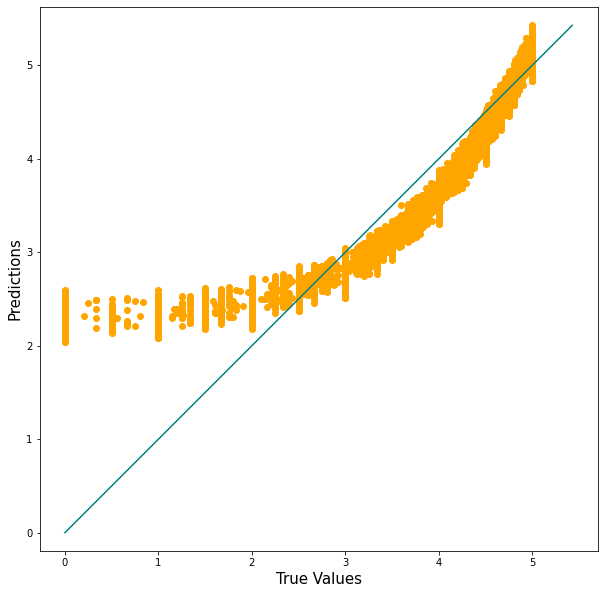

In [55]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_predict, c='orange')

p1 = max(max(y_test_predict), max(y_test))
p2 = min(min(y_test_predict), min(y_test))
plt.plot([p1, p2], [p1, p2], 'teal')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()